# Plot the chemical space at each iteration

## Read the data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from utils import InMemoryDatabase, IterativeDatabase

In [3]:
db = IterativeDatabase('AmpC')

In [4]:
from pathlib import Path

iterations = {
    i: np.load(f)
    for i, f in enumerate(sorted(Path("../active_learning/AmpC/molecules/").iterdir()))
    if f.suffix == ".npy"
}

In [5]:
scores = db.read_column('dockscore')

started read_column
  running read_column took 297.5860 sec


In [11]:
rv = []
fps_cols = [f"fps_{i:04}" for i in range(1024)]
for f in sorted(db.files):
    df = pd.read_parquet(f, engine="pyarrow")[fps_cols].astype(bool)
    rv.append(df)


In [12]:
df = pd.concat(rv)
df.head()

,fps_0000,fps_0001,fps_0002,fps_0003,fps_0004,fps_0005,fps_0006,fps_0007,fps_0008,fps_0009,...,fps_1014,fps_1015,fps_1016,fps_1017,fps_1018,fps_1019,fps_1020,fps_1021,fps_1022,fps_1023
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [13]:
for obj in rv:
    del obj
del rv

In [14]:
import gc
gc.collect()

0

In [15]:
iterations = {
    key: df.loc[val]
    for key, val in iterations.items()
}

In [22]:
idx = scores.argsort()
top_N = int(0.05 / 100 * len(scores))

top_idx = idx[:top_N]
top_fingerprints = df.loc[top_idx].values

In [23]:
import umap

# reducer = umap.UMAP().fit(subset)
subset = df.sample(n=1_000_000).values
reducer = umap.UMAP(metric='jaccard').fit(subset)

/home/marinegor/github/wiselydock-server/env/lib/python3.9/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


In [24]:
iterations_stacked = np.vstack([arr for arr in iterations.values()])
embedding = reducer.transform(iterations_stacked)

In [25]:
top_emgedding = reducer.transform(top_fingerprints)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


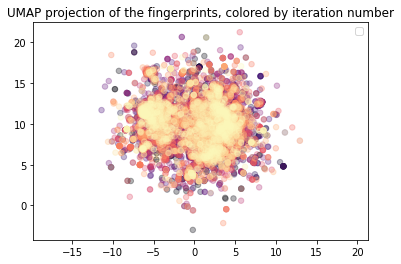

In [26]:
full_colors = np.array([i for i, arr in iterations.items() for _ in range(len(arr))])
skip = 100

x, y = (
    embedding[::skip, 0],
    embedding[::skip, 1],
)
colors = full_colors[::skip]

palette = sns.color_palette("magma", n_colors=len(set(colors)))
plt.scatter(
    x,
    y,
    c=[palette[x] for x in colors],
    s=30,
    alpha=0.3,
)

plt.gca().set_aspect("equal", "datalim")
plt.legend()
plt.title("UMAP projection of the fingerprints, colored by iteration number")
plt.savefig("AmpC_default_umap_embeddings.png", dpi=300)

In [43]:
full_colors = np.array([i for i, arr in iterations.items() for _ in range(len(arr))])
n_colors = len(set(full_colors))
xmin, xmax = embedding[:, 0].min(), embedding[:, 0].max()
ymin, ymax = embedding[:, 1].min(), embedding[:, 1].max()


def plot_top_on(ax: object, skip: int = 100, top_embedding=top_emgedding):
    sns.kdeplot(
        x=top_embedding[::skip, 0],
        y=top_embedding[::skip, 1],
        color="lightcoral",
        levels=10,
        alpha=0.7,
        ax=ax,
    )


def plot_for_iteration(n: int, ax: object, skip: int = 100, embedding=embedding):
    palette = sns.color_palette("crest", n_colors=n_colors)
    color = palette[n]
    (idx,) = np.where(full_colors == n)
    embedding = embedding[idx]

    x, y = (
        embedding[::skip, 0],
        embedding[::skip, 1],
    )

    sns.kdeplot(x=x, y=y, ax=ax, color=color, alpha=0.7, levels=40, fill=True)

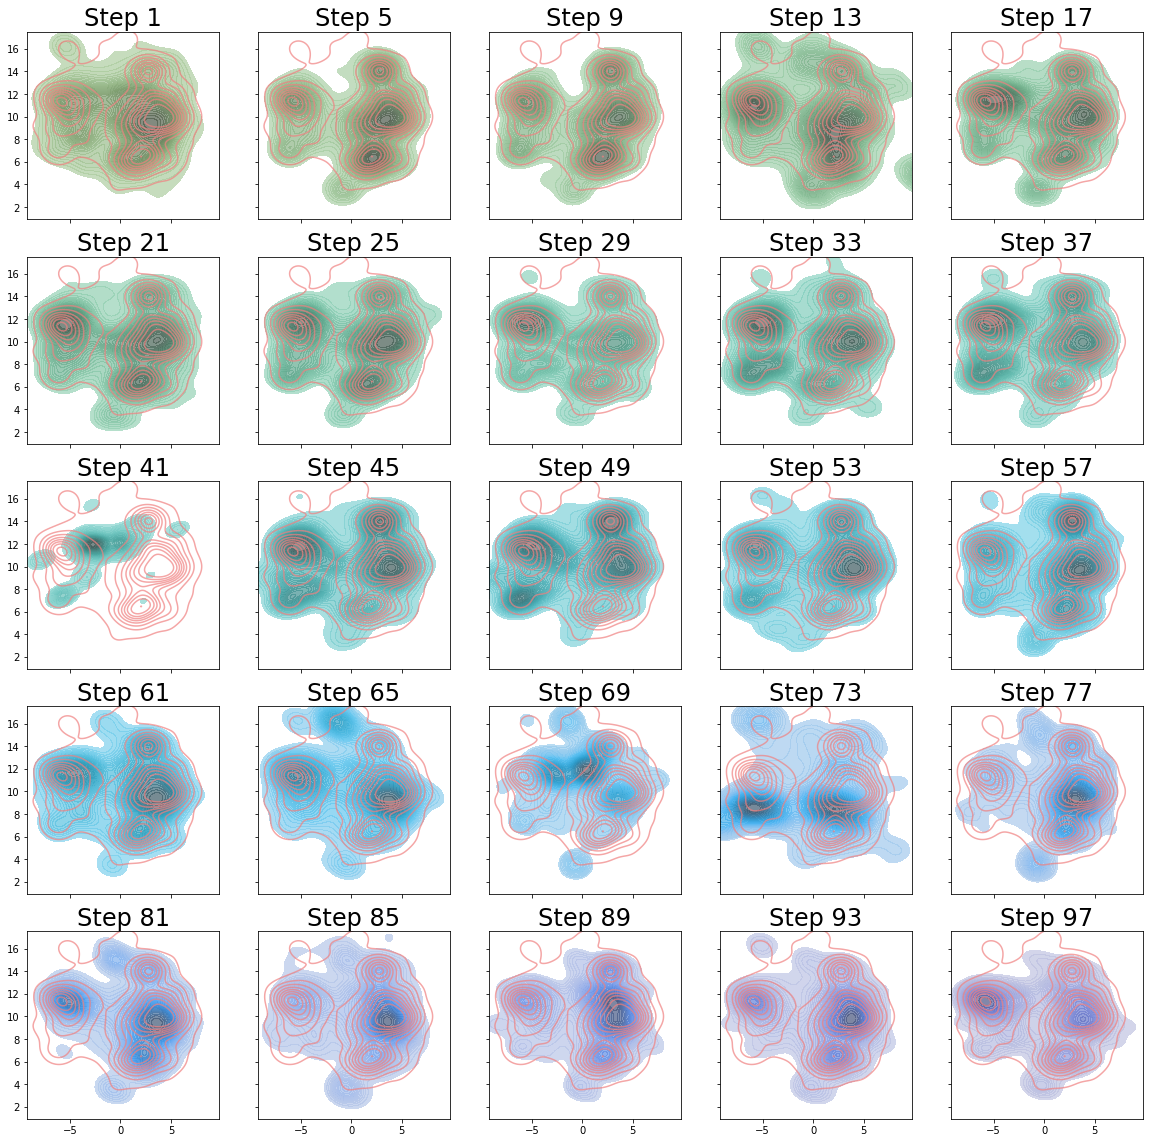

In [49]:
fig, axs = plt.subplots(5, 5, figsize=(4 * 5, 4 * 5), sharex=True, sharey=True)

x0 = y0 = float("inf")
x1 = y1 = float("-inf")
skip = 10

for i, ax in enumerate(axs.flatten()):
    plot_top_on(ax, skip=skip)
    plot_for_iteration(4 * i, ax, skip=skip)
    ax.set_title(f"Step {i*4+1}", size=24)
    # ax.axis('off')
    x0n, x1n = ax.get_xlim()
    y0n, y1n = ax.get_ylim()

    x0 = min(x0, x0n)
    x1 = max(x1, x1n)
    y0 = min(y0, y0n)
    y1 = max(y0, y1n)

dx = (x1 - x0) / 5
dy = (y1 - y0) / 5
x0, x1 = x0 + dx, x1 - dx
y0, y1 = y0 + dy, y1 - dy


plt.setp(axs, xlim=(x0, x1), ylim=(y0, y1))
plt.savefig("../Supp_Figure_X_jaccard_UMAP_kde.png", dpi=300)
# ax.set_xlim((xmin, xmax))
# ax.set_ylim((ymin, ymax))

In [5]:
import umap

In [6]:
n_bits = 7
iterations = {
    i: np.random.choice([True, False], size=(1_000, 2**n_bits)) for i in range(10)
}

In [7]:
N = 10_000
subset = np.random.choice([True, False], size=(N, 2**n_bits))

In [22]:
# reducer = umap.UMAP(metric='jaccard').fit(subset)
reducer = umap.UMAP().fit(subset)

In [23]:
iterations_stacked = np.vstack([arr for arr in iterations.values()])
embedding = reducer.transform(iterations_stacked)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'UMAP projection of the fingerprints, colored by iteration number')

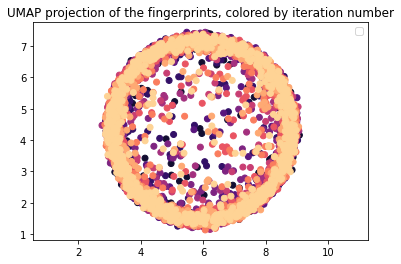

In [24]:
colors = [i for i, arr in iterations.items() for _ in range(len(arr))]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette("magma", n_colors=len(set(colors)))[x] for x in colors],
)
plt.gca().set_aspect("equal", "datalim")
plt.legend()
plt.title("UMAP projection of the fingerprints, colored by iteration number")

In [1]:
from utils import InMemoryDatabase, IterativeDatabase
from pathlib import Path
import numpy as np
import pandas as pd
from functools import lru_cache

TypeError: 'type' object is not subscriptable

In [ ]:
@lru_cache(maxsize=1)
def read_scores(db):
    rv = []
    for f in sorted(db.files):
        df = pd.read_parquet(f, engine="pyarrow")["dockscore"]
        rv.append(df)
    return pd.concat(rv)

In [16]:
df

,N_screened,percentage_screened,mean_score,min_score,shared_with_top_N,N_found_by_now,N_found_if_random,percentage_found,dataset
iteration_num,,,,,,,,,
0,0,0.000000,-28.389885,-66.73,8,8,10,0.013765,D4
1,20000,0.017206,-28.044563,-64.66,13,21,20,0.036132,D4
2,40000,0.034411,-44.311375,-66.05,223,244,30,0.419821,D4
3,60000,0.051617,-44.867902,-67.93,226,470,40,0.808672,D4
4,80000,0.068822,-43.897363,-68.39,189,659,50,1.133861,D4
...,...,...,...,...,...,...,...,...,...
95,1900000,1.974760,-49.166060,-92.77,320,31923,960,66.358326,AmpC
96,1920000,1.995547,-48.886088,-88.63,269,32192,970,66.917496,AmpC
97,1940000,2.016334,-47.908513,-87.91,196,32388,980,67.324922,AmpC


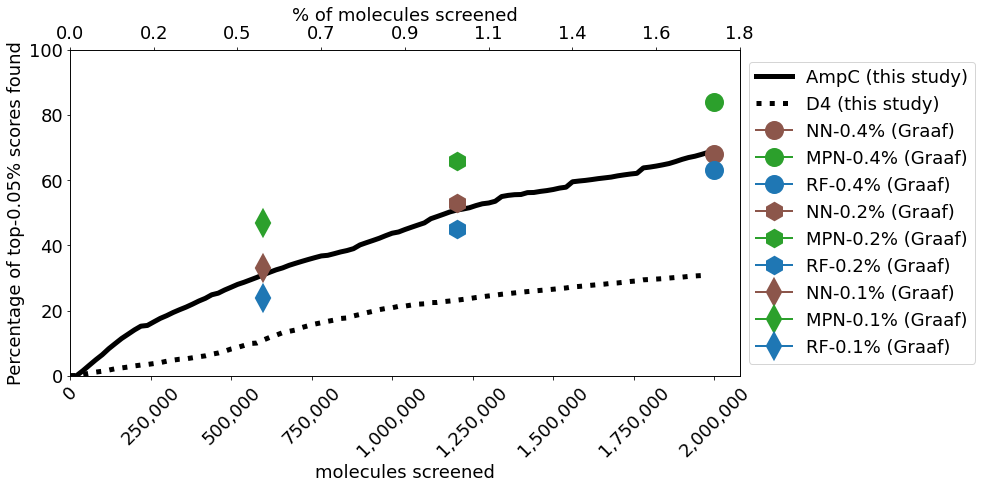

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter
import matplotlib

df = raw_data.query("dataset == 'AmpC'")
df_2 = raw_data.query('dataset == "D4"')

matplotlib.rcParams.update({"font.size": 18})

# Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot N_found on the primary Y-axis and n_screened on the primary X-axis
ax1.plot(
    df["N_screened"],
    df["percentage_found"],
    color="k",
    label="AmpC (this study)",
    linewidth=5,
)
ax1.plot(
    df_2["N_screened"],
    df_2["percentage_found"],
    color="k",
    linestyle=":",
    label="D4 (this study)",
    linewidth=5,
)
ax1.set_xlabel("molecules screened")
ax1.set_ylabel(r"Percentage of top-0.05% scores found", color="k")

# change y limit
ax1.set_ylim(0, 100)
ax1.set_xlim(0, None)

# change format of x axis
def format_x_axis_labels(x, pos):
    return "{:,.0f}".format(x)  # Format with commas for thousands


ax1.xaxis.set_major_formatter(FuncFormatter(format_x_axis_labels))
ax1.tick_params(axis="x", rotation=45)

# Create a secondary X-axis at the top
ax2 = ax1.twiny()

# Calculate n_screened divided by 2 million
ax2_ticks = np.arange(0, 2_000_000, 225_000) / 99_500_000 * 100
ax2.set_xticks(ax2_ticks)
ax2.set_xticklabels([f"{n:2.1f}" for n in ax2_ticks])

# Plot the secondary X-axis
ax2.set_xlim(
    (ax2_ticks.min(), ax2_ticks.max())
)  # Make sure the secondary X-axis has the same limits as the primary
ax2.set_xlabel(r"% of molecules screened")

# add values from the Graaf et al paper
deGraaf = {
    "NN-0.4% (Graaf)": (2_000_000, 0.68),
    "MPN-0.4% (Graaf)": (2_000_000, 0.84),
    "RF-0.4% (Graaf)": (2_000_000, 0.63),
    # ---
    "NN-0.2% (Graaf)": (1_200_000, 0.53),
    "MPN-0.2% (Graaf)": (1_200_000, 0.66),
    "RF-0.2% (Graaf)": (1_200_000, 0.45),
    # ---
    "NN-0.1% (Graaf)": (600_000, 0.33),
    "MPN-0.1% (Graaf)": (600_000, 0.47),
    "RF-0.1% (Graaf)": (600_000, 0.24),
}

colors = {"NN": "tab:brown", "MPN": "tab:green", "RF": "tab:blue"}
markers = {r"0.1%": "d", r"0.2%": "h", r"0.4%": "o"}

for label, (n_screened, p_found) in deGraaf.items():
    name, percentage = label.split("-")
    color = colors[name]
    marker = markers[percentage.split()[0]]
    p_found *= 100
    ax1.plot(
        n_screened,
        p_found,
        label=label,
        marker=marker,
        color=color,
        markersize=15,
        linewidth=2,
        markeredgewidth=4,
    )

# add legend
lines, labels = ax1.get_legend_handles_labels()
lgd = ax1.legend(lines, labels, loc="center left", bbox_to_anchor=(1, 0.5))

# Display the plot
plt.savefig(
    "../figures/figure_5_comparison.png",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
    dpi=300,
)